https://huggingface.co/cambridgeltl/BioRedditBERT-uncased

Reference - @inproceedings{basaldella-2020-cometa,
    title = "{COMETA}: A Corpus for Medical Entity Linking in the Social Media",
    author = "Basaldella, Marco  and Liu, Fangyu, and Shareghi, Ehsan, and Collier, Nigel",
    booktitle = "Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing",
    month = nov,
    year = "2020",
    publisher = "Association for Computational Linguistics"
}



In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.8 MB/s eta 0:00:00


##Import packages

In [2]:
#Ignore Warning
import warnings
warnings.filterwarnings("ignore") 
# set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate,Conv1D,MaxPool1D,Dropout

## Mount Google Drive to Colab environment

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/My Drive/MSDS/498-Capstone/NW-MSDS_CapstoneProject/
!pwd
#!ls
print('Working Directory')
print(os.getcwd())
work_dir = "/content/gdrive/My Drive/MSDS/498-Capstone/NW-MSDS_CapstoneProject/"

/content/gdrive/.shortcut-targets-by-id/1wHLGXlHrKWfJBcdQSt8SRTchDZIbjUV8/NW-MSDS_CapstoneProject
/content/gdrive/.shortcut-targets-by-id/1wHLGXlHrKWfJBcdQSt8SRTchDZIbjUV8/NW-MSDS_CapstoneProject
Working Directory
/content/gdrive/.shortcut-targets-by-id/1wHLGXlHrKWfJBcdQSt8SRTchDZIbjUV8/NW-MSDS_CapstoneProject


In [6]:
biobert_tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/BioRedditBERT-uncased")
biobert_model = TFAutoModel.from_pretrained("cambridgeltl/BioRedditBERT-uncased")

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at cambridgeltl/BioRedditBERT-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
biobert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Read the pickle files
# train = pd.read_pickle(work_dir + 'data/final/train.pkl')
# val = pd.read_pickle(work_dir + 'data/final/val.pkl')
# test = pd.read_pickle(work_dir + 'data/final/test.pkl')

train=pd.read_csv(work_dir + 'data/final/train_data_chatbot.csv')
val=pd.read_csv(work_dir + 'data/final/val_data_chatbot.csv')
test=pd.read_csv(work_dir + 'data/final/test_data_chatbot.csv')

In [9]:
train.shape
val.shape
test.shape

(42795, 6)

(4755, 6)

(5284, 6)

In [10]:
MAX_LENGTH=512

In [11]:
def tokenize_and_filter(questions, answers):
  tokenized_questions, tokenized_answers = [], []
  
  for (question, answer) in zip(questions, answers):
    # generating sequences
    tokenized_question =  biobert_tokenizer.encode(question)
    tokenized_answer = biobert_tokenizer.encode(answer)
    tokenized_questions.append(tokenized_question)
    tokenized_answers.append(tokenized_answer)

  # padding the sequences
  tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_questions, maxlen=MAX_LENGTH, padding='post')
  tokenized_answers = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_answers, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_questions, tokenized_answers

In [12]:
train_questions=train['short_question_pre']
train_answers=train['short_answer_pre']
train_labels=train['label']
     
#tokenizing and padding the train questions and answers
train_questions, train_answers = tokenize_and_filter(train_questions, train_answers)

In [13]:
train_questions

array([[  101,  1229,  1515, ...,     0,     0,     0],
       [  101,  1209, 13477, ...,     0,     0,     0],
       [  101,  1132, 23971, ...,     0,     0,     0],
       ...,
       [  101,   178,  1138, ...,     0,     0,     0],
       [  101,  1180,   178, ...,     0,     0,     0],
       [  101,   178,  1138, ...,     0,     0,     0]], dtype=int32)

In [14]:
train_answers

array([[  101,  1128,  1138, ...,     0,     0,     0],
       [  101,  1142,  1110, ...,     0,     0,     0],
       [  101,  2999,  1185, ...,     0,     0,     0],
       ...,
       [  101,  1211, 14739, ...,     0,     0,     0],
       [  101,   178,  1821, ...,     0,     0,     0],
       [  101, 20844,  1396, ...,     0,     0,     0]], dtype=int32)

In [15]:
train_labels.value_counts()

 1    21398
-1    21397
Name: label, dtype: int64

In [16]:
#preparing the question mask and the answer mask of the train dataset
train_question_mask=[[1 if token!=0 else 0 for token in question] for question in train_questions]
train_answer_mask=[[1 if token!=0 else 0 for token in answer] for answer in train_answers]

In [17]:
# val.drop(['index'], inplace=True)
# test.drop(['index'], inplace=True)
#df_val.reset_index(drop=True, inplace=True)

In [18]:
# val.reset_index(drop=True, inplace=True)
# test.reset_index()

In [19]:
#extracting the short answers and questions from the validation data
val_questions=val['short_question_pre']
val_answers=val['short_answer_pre']
val_labels=val['label']

In [20]:
#tokenizing and padding the validation question and answers
val_questions, val_answers = tokenize_and_filter(val_questions, val_answers)

In [21]:
val_labels.value_counts()

-1    2378
 1    2377
Name: label, dtype: int64

In [22]:
val_labels.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: label, dtype: int64

In [23]:
#preparing the question and answer mask for the validation data
val_question_mask=[[1 if token!=0 else 0 for token in question] for question in val_questions]
val_answer_mask=[[1 if token!=0 else 0 for token in answer] for answer in val_answers]

In [24]:
#extracting the short answers and questions from the test data
test_questions=test['short_question_pre']
test_answers=test['short_answer_pre']
test_labels=test['label']

In [25]:
#tokenizing and padding the test question and answers
test_questions, test_answers = tokenize_and_filter(test_questions, test_answers)

In [26]:
#preparing the question and answer mask for the test data
test_question_mask=[[1 if token!=0 else 0 for token in question] for question in test_questions]
test_answer_mask=[[1 if token!=0 else 0 for token in answer] for answer in test_answers]

In [27]:
#Reference - https://github.com/re-search/DocProduct/blob/master/docproduct/models.py
class FFN(tf.keras.layers.Layer):
    def __init__(
            self,
            name='FFN',
            **kwargs):
        """Simple Dense wrapped with various layers
        """

        super(FFN, self).__init__(name=name, **kwargs)
        self.dropout = 0.2
        self.ffn_layer = tf.keras.layers.Dense(
            units=768,
            activation='relu',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')
        

    def call(self, inputs):
        ffn_embedding = self.ffn_layer(inputs)
        ffn_embedding = tf.keras.layers.Dropout(
            self.dropout)(ffn_embedding)
        ffn_embedding += inputs
        return ffn_embedding

In [28]:
#displaying the biobert model summary
biobert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [29]:
class MedBOTBert(tf.keras.Model):
    def __init__(
            self,
            trainable=False,
            name=''):
        super(MedBOTBert, self).__init__(name=name)

        self.q_ffn_layer = FFN(name='q_ffn')
        self.a_ffn_layer = FFN(name='a_ffn')
        self.biobert_model=biobert_model
        self.biobert_model.trainable=trainable
        self.cos=tf.keras.layers.Dot(axes=1,normalize=True)

    def call(self, inputs):
      question_embeddings=self.biobert_model(input_ids=inputs['question'],attention_mask=inputs['question_mask']).pooler_output
      answer_embeddings=self.biobert_model(input_ids=inputs['answer'],attention_mask=inputs['answer_mask']).pooler_output
      q_ffnn=self.q_ffn_layer(question_embeddings)
      a_ffnn=self.a_ffn_layer(answer_embeddings)
      output=self.cos([q_ffnn,a_ffnn])
      return {"label":output}

In [30]:
#https://blog.tensorflow.org/2019/05/transformer-chatbot-tutorial-with-tensorflow-2.html
#preparing the training  dataset
import tensorflow as tf
BATCH_SIZE = 2
BUFFER_SIZE = 20000
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': train_questions,
        'answer': train_answers,
        'question_mask':train_question_mask,
        'answer_mask':train_answer_mask
    },
    {
        'label': train_labels.values
    },
))

# dataset = dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE,drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [31]:
train_dataset

<PrefetchDataset element_spec=({'question': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'answer': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'question_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'answer_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None)}, {'label': TensorSpec(shape=(2,), dtype=tf.int64, name=None)})>

In [32]:
import tensorflow as tf
BATCH_SIZE = 2
BUFFER_SIZE = 20000
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'question': val_questions,
        'answer': val_answers,
        'question_mask':val_question_mask,
        'answer_mask':val_answer_mask
    },
    {
        'label': val_labels.values
    },
))

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [33]:
val_dataset

<PrefetchDataset element_spec=({'question': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'answer': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'question_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None), 'answer_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None)}, {'label': TensorSpec(shape=(2,), dtype=tf.int64, name=None)})>

In [34]:
class custom_callback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'acc': []}

  def on_epoch_end(self, epoch, logs={}):
        self.history['acc'].append(logs.get('custom_metric_acc'))

        #saving the model if validation accuracy increased from previous epoch
        if  (epoch==0) or (logs.get('custom_metric_acc')>self.history['acc'][epoch-1]):
          self.model.save_weights(work_dir + 'BioBert_model/medical_bert_re'+str(epoch)+'/medic'+str(epoch)+'_'+str(logs.get('custom_metric_acc')))
          
        is_nan_values=[]
        for i in self.model.get_weights():
          is_nan_values.append(np.isnan(i).any())

        #stopping the training if weights is nan or loss is nan or inf
        if (np.array(is_nan_values).any() or (tf.math.is_nan(logs.get('loss'))) or (np.isinf(logs.get('loss')))):
          self.model.stop_training = True

In [35]:
batch_size=2
def custom_metric_acc(y_true,y_pred):
  y_true=tf.reshape(y_true,[tf.constant(batch_size)])
  y_pred=tf.reshape(y_pred,[tf.constant(batch_size)])
  c=tf.constant(0,dtype='float32')
  d=tf.cast(tf.math.greater_equal(y_true,c),dtype='float32')
  e=tf.cast(tf.math.greater_equal(y_pred,c),dtype='float32')
  f=tf.cast(tf.math.equal(d,e),dtype='float32')
  g=tf.reduce_sum(f)
  h=tf.cast(tf.shape(f),dtype='float32')
  i=g/h
  return i

In [36]:
tf.keras.backend.set_floatx('float32')
learning_rate = 0.000005
num_epochs=5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
medBotBioBert_model=MedBOTBert(trainable=True)
medBotBioBert_model.compile(
    optimizer=optimizer, loss=tf.keras.losses.mean_squared_error, metrics=[custom_metric_acc])

epochs = num_epochs

history= medBotBioBert_model.fit(train_dataset,validation_data=val_dataset,epochs=epochs,callbacks=[custom_callback()])

Epoch 1/5
21397/21397 [==============================] - 1698s 77ms/step - loss: 0.7559 - custom_metric_acc: 0.7187 - val_loss: 0.6427 - val_custom_metric_acc: 0.7711
Epoch 2/5
21397/21397 [==============================] - 1576s 74ms/step - loss: 0.5798 - custom_metric_acc: 0.8165 - val_loss: 0.5839 - val_custom_metric_acc: 0.8063
Epoch 3/5
21397/21397 [==============================] - 1572s 73ms/step - loss: 0.5222 - custom_metric_acc: 0.8475 - val_loss: 0.5910 - val_custom_metric_acc: 0.8004
Epoch 4/5
21397/21397 [==============================] - 1574s 74ms/step - loss: 0.4766 - custom_metric_acc: 0.8702 - val_loss: 0.5894 - val_custom_metric_acc: 0.8054
Epoch 5/5
21397/21397 [==============================] - 1574s 74ms/step - loss: 0.4334 - custom_metric_acc: 0.8895 - val_loss: 0.6124 - val_custom_metric_acc: 0.7867


In [37]:
medBotBioBert_model.summary()

Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_ffn (FFN)                 multiple                  590592    
                                                                 
 a_ffn (FFN)                 multiple                  590592    
                                                                 
 tf_bert_model (TFBertModel)  multiple                 108310272 
                                                                 
 dot (Dot)                   multiple                  0         
                                                                 
Total params: 109,491,456
Trainable params: 109,491,456
Non-trainable params: 0
_________________________________________________________________


In [41]:
def draw_learning_curve(history, keys=['custom_metric_acc', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.grid(True)
        plt.gca().set_ylim(0, 1)
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='best')
    plt.show()

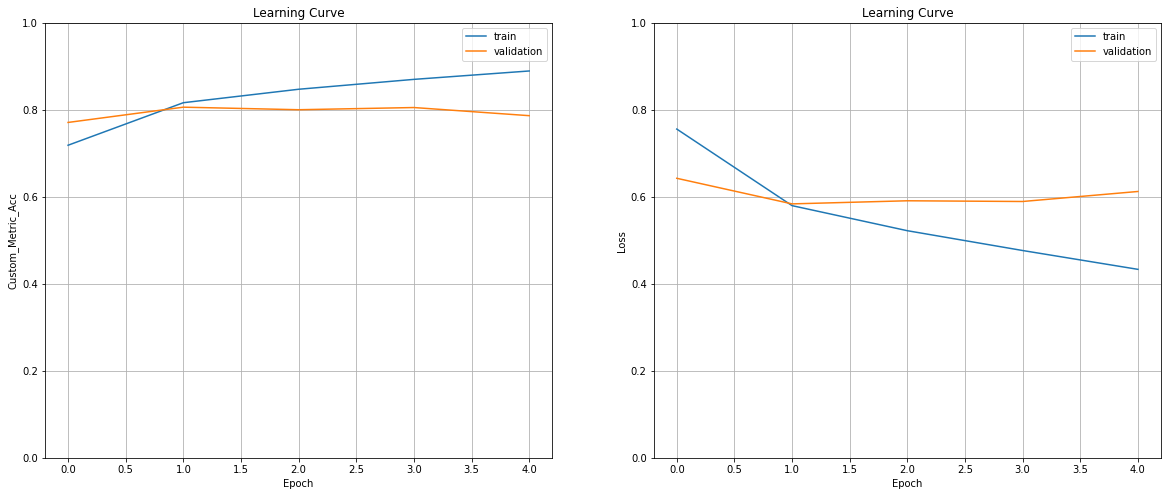

In [42]:
draw_learning_curve(history)

Text(0.5, 1.0, 'Training and validation accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

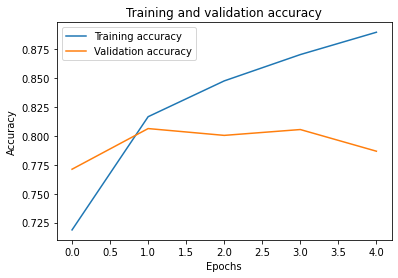

In [38]:
plt.plot(history.history["custom_metric_acc"], label="Training accuracy")
plt.plot(history.history["val_custom_metric_acc"], label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
import tensorflow.keras.backend as K
K.set_floatx('float32')
medical_qa_model=MedBOTBert(trainable=True)
medical_qa_model.load_weights(work_dir + 'medical_bert_re4/medic4_0.9220919013023376')
learning_rate=0.000005
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
medical_qa_model.compile(
    optimizer=optimizer, loss=tf.keras.losses.mean_squared_error, metrics=[custom_metric_acc])



In [ ]:
# original_labels=[]
predicted_labels=[]
from tqdm.notebook import tqdm
for i in tqdm(range(len(val_questions))):
  predicted_labels.append(medical_qa_model.predict({'question':np.array([val_questions[i]]),'question_mask':np.array([val_question_mask[i]]),
                             'answer':np.array([val_answers[i]]),'answer_mask':np.array([val_answer_mask[i]])})['label'][0][0])


  0%|          | 0/4755 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


In [ ]:
# Learning curve function to visualize accuracy and loss in train and validation set.
def draw_learning_curve(history, keys=['custom_metric_acc', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
# Visualize learning curve for model 1 - unidirectional 1 layer simplernn.
draw_learning_curve(history)

In [ ]:
predicted_labels

[-0.14181837,
 -0.041992772,
 -0.5827365,
 -0.35399586,
 -0.26753306,
 -0.77161187,
 0.7564556,
 -0.52976376,
 0.44713378,
 0.58047944,
 -0.38064796,
 -0.14152488,
 0.6241165,
 0.38610494,
 0.2526378,
 0.4250347,
 -0.15108982,
 -0.6216967,
 -0.058975194,
 0.55329376,
 0.86993486,
 0.4432131,
 0.2199423,
 -0.41462728,
 0.62545586,
 0.6233346,
 -0.73139256,
 0.6518469,
 -0.639582,
 -0.49961266,
 -0.08166244,
 0.5412301,
 0.7667656,
 0.01487178,
 0.68483377,
 0.6241622,
 0.09243208,
 -0.595311,
 0.60303307,
 0.6927558,
 0.7042357,
 -0.008012263,
 0.78500223,
 0.8678088,
 0.55816317,
 -0.4892391,
 0.59318405,
 -0.52699083,
 0.59288764,
 0.20829187,
 0.67959034,
 0.7510772,
 0.4585632,
 0.69842756,
 -0.31316096,
 -0.7746897,
 0.6157569,
 -0.8185438,
 0.01808351,
 0.56019783,
 -0.21321467,
 -0.011551574,
 -0.16758776,
 -0.29761058,
 0.7151502,
 0.6337073,
 -0.23694785,
 0.6517876,
 0.5675815,
 -0.026479285,
 0.5849819,
 0.21087717,
 -0.35210252,
 0.46745914,
 -0.34280246,
 -0.7210325,
 0.657

In [ ]:
#defining function to return accuracy, correctly predicted positive points and correctly predicted negative points
def acc_threshold(predicted_labels,true_labels,threshold):
  correct_pred_pos=[]
  correct_pred_neg=[]
  for i in range(len(predicted_labels)):
    # print("predicted = ", predicted_labels[i])
    # print("threshold = ", threshold)
    # print("val_labels = ", val_labels[i])
    if predicted_labels[i] > threshold and true_labels[i]==1:
      correct_pred_pos.append(predicted_labels[i])
    else:
      correct_pred_neg.append(predicted_labels[i])
  acc=len(correct_pred_pos+correct_pred_neg)/len(predicted_labels)
  print('accuracy for threshold',threshold,'is',acc)
  return (acc,correct_pred_pos,correct_pred_neg)

In [ ]:
def best_threshold_acc(predicted_labels, true_labels):
  acc=[]
  thresholds=np.array(range(-10,11,1))*0.1
  for i in tqdm(range(-10,11,1)):
    acc.append(acc_threshold(predicted_labels,true_labels,i*0.1)[0])
  print('best accuracy is',max(acc),'at threshold',thresholds[np.argmax(acc)])

In [ ]:
val_labels.tail()

4750   -1
4751    1
4752   -1
4753    1
4754    1
Name: label, dtype: int64

In [ ]:
best_threshold_acc(predicted_labels, val_labels)

  0%|          | 0/21 [00:00<?, ?it/s]

accuracy for threshold -1.0 is 1.0
accuracy for threshold -0.9 is 1.0
accuracy for threshold -0.8 is 1.0
accuracy for threshold -0.7000000000000001 is 1.0
accuracy for threshold -0.6000000000000001 is 1.0
accuracy for threshold -0.5 is 1.0
accuracy for threshold -0.4 is 1.0
accuracy for threshold -0.30000000000000004 is 1.0
accuracy for threshold -0.2 is 1.0
accuracy for threshold -0.1 is 1.0
accuracy for threshold 0.0 is 1.0
accuracy for threshold 0.1 is 1.0
accuracy for threshold 0.2 is 1.0
accuracy for threshold 0.30000000000000004 is 1.0
accuracy for threshold 0.4 is 1.0
accuracy for threshold 0.5 is 1.0
accuracy for threshold 0.6000000000000001 is 1.0
accuracy for threshold 0.7000000000000001 is 1.0
accuracy for threshold 0.8 is 1.0
accuracy for threshold 0.9 is 1.0
accuracy for threshold 1.0 is 1.0
best accuracy is 1.0 at threshold -1.0


accuracy for threshold 0.8 is 1.0


Text(0.5, 1.0, 'Correctly predicted labels')

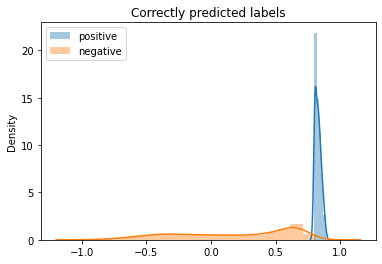

In [ ]:
_,correct_pred_pos,correct_pred_neg=acc_threshold(predicted_labels,0.8)
sns.distplot(correct_pred_pos,label='positive')
sns.distplot(correct_pred_neg,label='negative')
plt.title('Correctly predicted labels')
plt.legend()
plt.show()

In [ ]:
test_predicted_labels=[]
for i in tqdm(range(len(test_questions))):
  test_predicted_labels.append(medical_qa_model.predict({'question':np.array([test_questions[i]]),'question_mask':np.array([test_question_mask[i]]),
                             'answer':np.array([test_answers[i]]),'answer_mask':np.array([test_answer_mask[i]])})['label'][0][0])

  0%|          | 0/5284 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


In [ ]:
best_threshold_acc(test_predicted_labels, test_labels)

  0%|          | 0/21 [00:00<?, ?it/s]

accuracy for threshold -1.0 is 1.0
accuracy for threshold -0.9 is 1.0
accuracy for threshold -0.8 is 1.0
accuracy for threshold -0.7000000000000001 is 1.0
accuracy for threshold -0.6000000000000001 is 1.0
accuracy for threshold -0.5 is 1.0
accuracy for threshold -0.4 is 1.0
accuracy for threshold -0.30000000000000004 is 1.0
accuracy for threshold -0.2 is 1.0
accuracy for threshold -0.1 is 1.0
accuracy for threshold 0.0 is 1.0
accuracy for threshold 0.1 is 1.0
accuracy for threshold 0.2 is 1.0
accuracy for threshold 0.30000000000000004 is 1.0
accuracy for threshold 0.4 is 1.0
accuracy for threshold 0.5 is 1.0
accuracy for threshold 0.6000000000000001 is 1.0
accuracy for threshold 0.7000000000000001 is 1.0
accuracy for threshold 0.8 is 1.0
accuracy for threshold 0.9 is 1.0
accuracy for threshold 1.0 is 1.0
best accuracy is 1.0 at threshold -1.0


accuracy for threshold 0.3 is 1.0


Text(0.5, 1.0, 'Correctly predicted test labels')

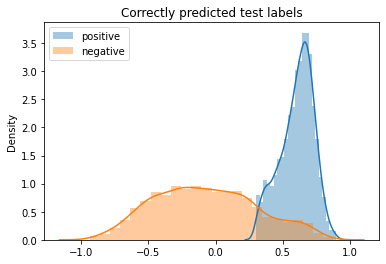

In [ ]:
_,correct_test_pred_pos,correct_test_pred_neg=acc_threshold(test_predicted_labels,test_labels,0.3)
sns.distplot(correct_test_pred_pos,label='positive')
sns.distplot(correct_test_pred_neg,label='negative')
plt.title('Correctly predicted test labels')
plt.legend()
plt.show()

In [ ]:
#finding incorrectly predicted positive and negative points
incorrect_pos=[]
incorrect_neg=[]
for i in range(len(val_labels)):
  if val_labels[i]==1 and predicted_labels[i]<0.3:
    incorrect_pos.append(predicted_labels[i])
  elif val_labels[i]==-1 and predicted_labels[i]>=0.3:
    incorrect_neg.append(predicted_labels[i])
     

Text(0.5, 1.0, 'Incorrectly predicted points')

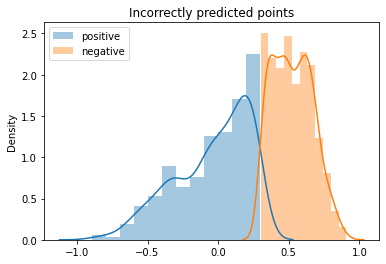

In [ ]:
#plotting the pdf of model predicted similarities for incorrectly predicted positive and negative points
sns.distplot(incorrect_pos,label='positive')
sns.distplot(incorrect_neg,label='negative')
plt.title('Incorrectly predicted points')
plt.legend()
plt.show()

From the above plots we can observe that most of the correctly classified points are well seperated and even though accuracy is about 92% on train data, most of the misclassified points lie within the threshold of 0.3

##Extract embedding from model

In [ ]:
#loading the trained medical bert model with best validation accuracy from above checkpoint
medbot_qna_model=MedBOTBert(trainable=True)
medbot_qna_model.load_weights(work_dir + 'medical_bert_re0/medic0_0.8326634764671326')

In [ ]:
#defining the question extractor model
x1=tf.keras.layers.Input((512),name='question',dtype='int64')
x2=tf.keras.layers.Input((512),name='question_mask',dtype='int64')
q_embed=medbot_qna_model.get_layer('q_ffn')(medbot_qna_model.get_layer('tf_bert_model').bert(input_ids=x1,attention_mask=x2,).pooler_output)
question_extractor_model=tf.keras.Model(inputs=[x1,x2],outputs=q_embed)

In [ ]:
question_extractor_model.save(work_dir + 'question_extractor_model')

In [ ]:
#loading the saved question extractor model from disk
question_extractor_model_loaded=tf.keras.models.load_model(work_dir + 'question_extractor_model')

In [ ]:
#function to extract embeddings given a question and a question mask
def question_extractor(q_dict):
  q_embed=question_extractor_model_loaded({'question':q_dict['question'],'question_mask':q_dict['question_mask']})
  return q_embed
  

In [ ]:
#defining function to extract question embeddings given question
def extract_question_embed(question):
  max_length=512
  tokenized_questions=[]
  tokenized_question =  biobert_tokenizer.encode(question)
  tokenized_questions.append(tokenized_question)

  # padding the sequences
  tokenized_questions = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_questions, maxlen=max_length, padding='post')
  attention_mask=[[1 if token>0 else 0 for token in q] for q in tokenized_questions]
  return question_extractor({'question':np.array(tokenized_questions),'question_mask':np.array(attention_mask)})

In [ ]:
#defining the answer extractor model
x1=tf.keras.layers.Input((512),name='answer',dtype='int64')
x2=tf.keras.layers.Input((512),name='answer_mask',dtype='int64')
a_embed=medbot_qna_model.get_layer('a_ffn')(medbot_qna_model.get_layer('tf_bert_model').bert(input_ids=x1,attention_mask=x2,).pooler_output)
answer_extractor_model=tf.keras.Model(inputs=[x1,x2],outputs=a_embed)

In [ ]:
answer_extractor_model.save(work_dir + 'answer_extractor_model')

In [ ]:
#loading the saved answer extractor model from disk
answer_extractor_model_loaded=tf.keras.models.load_model(work_dir + 'answer_extractor_model')

In [ ]:
#function to extract embeddings given an answer and an answer mask
def answer_extractor(ans_dict):
  a_embed=answer_extractor_model_loaded({'answer':ans_dict['answer'],'answer_mask':ans_dict['answer_mask']})
  return a_embed

In [ ]:
#defining function to extract answer embeddings
def extract_answer_embed(answer):
  max_length=512
  tokenized_answers=[]
  tokenized_answer =  biobert_tokenizer.encode(answer)
  tokenized_answers.append(tokenized_answer)

  # padding the sequences
  tokenized_answers = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_answers, maxlen=max_length, padding='post')
  attention_mask=[[1 if token>0 else 0 for token in q] for q in tokenized_answers]
  return answer_extractor({'answer':np.array(tokenized_answers),'answer_mask':np.array(attention_mask)})

In [ ]:
#extracting the original(without negative sampling) train dataset
pos_train_sample=train[train.label==1.0].copy()
pos_train_sample.shape

(21398, 6)

In [ ]:
#extracting the original(without negative sampling) validation dataset
pos_val_sample=val[val.label==1.0].copy()
pos_val_sample.shape

(2377, 6)

In [ ]:
#extracting the original(without negative sampling) test dataset
pos_test_sample=test[test.label==1.0].copy()
pos_test_sample.shape

(2642, 6)

In [ ]:
#extracting the question embeddings of train data
from tqdm.notebook import tqdm
tqdm.pandas()
pos_train_sample['short_question_embed']=pos_train_sample.short_question_pre.progress_apply(lambda x: extract_question_embed(x))

  0%|          | 0/21398 [00:00<?, ?it/s]

In [ ]:
#extracting the question embeddings of validation data
pos_val_sample['short_question_embed']=pos_val_sample.short_question_pre.progress_apply(lambda x: extract_question_embed(x))

  0%|          | 0/2377 [00:00<?, ?it/s]

In [ ]:
#extracting the question embeddings of test data
pos_test_sample['short_question_embed']=pos_test_sample.short_question_pre.progress_apply(lambda x: extract_question_embed(x))

  0%|          | 0/2642 [00:00<?, ?it/s]

In [ ]:
#extracting the answer embeddings of train data
pos_train_sample['short_answer_embed']=pos_train_sample.short_answer_pre.progress_apply(lambda x: extract_answer_embed(x))

  0%|          | 0/21398 [00:00<?, ?it/s]

In [ ]:
#extracting the answer embeddings of validation data
pos_val_sample['short_answer_embed']=pos_val_sample.short_answer_pre.progress_apply(lambda x: extract_answer_embed(x))

  0%|          | 0/2377 [00:00<?, ?it/s]

In [ ]:
#extracting the answer embeddings of test data
pos_test_sample['short_answer_embed']=pos_test_sample.short_answer_pre.progress_apply(lambda x: extract_answer_embed(x))

  0%|          | 0/2642 [00:00<?, ?it/s]

In [ ]:
#converting embeddings from tensors to numpy arrays
pos_train_sample['short_answer_embed_numpy']=pos_train_sample.short_answer_embed.apply(lambda x: x.numpy() )
pos_train_sample['short_question_embed_numpy']=pos_train_sample.short_question_embed.apply(lambda x: x.numpy())

In [ ]:
#converting embeddings from tensors to numpy arrays
pos_val_sample['short_answer_embed_numpy']=pos_val_sample.short_answer_embed.apply(lambda x: x.numpy() )
pos_val_sample['short_question_embed_numpy']=pos_val_sample.short_question_embed.apply(lambda x: x.numpy())

In [ ]:
#converting embeddings from tensors to numpy arrays
pos_test_sample['short_answer_embed_numpy']=pos_test_sample.short_answer_embed.apply(lambda x: x.numpy() )
pos_test_sample['short_question_embed_numpy']=pos_test_sample.short_question_embed.apply(lambda x: x.numpy())

In [ ]:
#Saving train question and answer embeddings to disk
pos_train_sample.drop(['short_answer_embed','short_question_embed'],axis=1).to_csv(work_dir + 'data/embedding/re_train_embeds.csv',index=False)
     

In [ ]:
pos_train_sample.shape

(21398, 10)

In [ ]:
pos_train_sample.head()

,short_question,short_answer,short_question_pre,short_answer_pre,tags,label,short_question_embed,short_answer_embed,short_answer_embed_numpy,short_question_embed_numpy
0,sex felt hard painful snap inside penis halfwa...,penile fracture significant chance develop sca...,while having sex i felt a hard painful snap in...,you have had a penile fracture and there is a ...,"['sexual intercourse', 'penis', 'pain', 'lump']",1,"((tf.Tensor(-0.6047527, shape=(), dtype=float3...","((tf.Tensor(0.33637145, shape=(), dtype=float3...","[[0.33637145, 0.903654, -0.9458587, -0.4416839...","[[-0.6047527, -0.94729406, -0.91843134, -0.785..."
1,spraying furniture rubbing alcohol cleaning ki...,necessary human head louse egg live long furni...,will spraying furniture with rubbing alcohol a...,this is not necessary human head lice and thei...,['lice'],1,"((tf.Tensor(-0.1739369, shape=(), dtype=float3...","((tf.Tensor(0.6966797, shape=(), dtype=float32...","[[0.6966797, 1.2845362, -0.15401514, -0.858057...","[[-0.1739369, -0.8185432, 0.38514182, -0.95360..."
3,neuroleptic drug parkinson disease,neuroleptic drug also called major tranquilize...,what are neuroleptic drugs for parkinson is di...,neuroleptic drugs also called major tranquiliz...,"[""parkinson's disease"", 'drug']",1,"((tf.Tensor(-0.29387322, shape=(), dtype=float...","((tf.Tensor(0.29717866, shape=(), dtype=float3...","[[0.29717866, 1.4708629, -0.56074375, -0.64780...","[[-0.29387322, -0.865726, -0.3979731, -0.73715..."
4,peanut help prevent headache told eat handful ...,apple day keep doctor away heard handful peanu...,do peanuts help prevent headaches have been to...,an apple a day keeps the doctor away but i hav...,"['peanut', 'headache']",1,"((tf.Tensor(-0.23108998, shape=(), dtype=float...","((tf.Tensor(0.22861195, shape=(), dtype=float3...","[[0.22861195, 0.99265194, -0.75949425, -0.2209...","[[-0.23108998, -0.8298196, -0.74065125, -0.433..."
6,osteoarthritis diagnosed,doctor make diagnosis oa based physical exam h...,how is osteoarthritis diagnosed,doctors make a diagnosis of oa based on a phys...,['osteoarthritis'],1,"((tf.Tensor(-0.6990545, shape=(), dtype=float3...","((tf.Tensor(-0.10100315, shape=(), dtype=float...","[[-0.10100315, 0.81206137, -0.6272399, 0.94998...","[[-0.6990545, -0.92379653, -0.74066365, 0.9598..."


In [ ]:
#Saving validation question and answer embeddings to disk
pos_val_sample.drop(['short_answer_embed','short_question_embed'],axis=1).to_csv(work_dir + 'data/embedding/re_val_embeds.csv',index=False)
     

In [ ]:
#Saving test question and answer embeddings to disk
pos_test_sample.drop(['short_answer_embed','short_question_embed'],axis=1).to_csv(work_dir + 'data/embedding/re_test_embeds.csv',index=False)
     